In [1]:
import numpy as np
import pandas as pd 
from sklearn.metrics import r2_score, mean_squared_error
import sys
import os
from joblib import load
import matplotlib.pyplot as plt
# make paths above 'notebooks/' visible for local imports.
# +----------------------------------------------------------------------------+
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.processing import GatherFeatureDatasets
from src import plotting

In [2]:
magdir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes'
data_dir = os.path.join(magdir, 'feature_splits')
use_mean = False
replace_all = True

In [3]:

def get_depth_baz_results(selected_feat_dict, 
                          station_meta_dict,
                          phase,
                          model_dir,
                          all_train_df,
                          depth_ind,
                          baz_ind):
    depth_r2_summary = {}
    baz_r2_summary = {}
    for stat in selected_feat_dict.keys():
        print(f'{stat}.{phase}.scaler.joblib',  f'{stat}.{phase}.SVR.joblib')
        scaler = load(os.path.join(model_dir, f'{stat}.{phase}.scaler.joblib'))
        svm_model = load(os.path.join(model_dir, f'{stat}.{phase}.SVR.joblib'))
        mean_depth = all_train_df[all_train_df.station == stat].drop_duplicates('Evid')['source_depth_km'].mean()
        mean_baz = all_train_df[all_train_df.station == stat].drop_duplicates('Evid')['source_receiver_back_azimuth'].mean()
        print(mean_depth, mean_baz)
        stat_depth = {}
        stat_baz = {}
        for ds in ['test', 'holdout']:
            if selected_feat_dict[stat][f'X_{ds}'] is None:
                stat_depth[f'{ds}_r2'] = None
                stat_baz[f'{ds}_r2'] = None
                continue

            X_depth = np.copy(selected_feat_dict[stat][f'X_{ds}'])
            X_depth[:, depth_ind] = mean_depth

            X_baz = np.copy(selected_feat_dict[stat][f'X_{ds}'])
            X_baz[:, baz_ind] = mean_baz   

            yhat_depth = svm_model.predict(scaler.transform(X_depth))
            yhat_baz = svm_model.predict(scaler.transform(X_baz))

            depth_r2 = r2_score(station_meta_dict[stat][f'y_{ds}'], yhat_depth)
            baz_r2 = r2_score(station_meta_dict[stat][f'y_{ds}'], yhat_baz)

            stat_depth[f'{ds}_r2'] = depth_r2
            stat_baz[f'{ds}_r2'] = baz_r2

        depth_r2_summary[stat] = stat_depth
        baz_r2_summary[stat] = stat_baz

    return pd.DataFrame(depth_r2_summary).T, pd.DataFrame(baz_r2_summary).T

In [4]:
def get_depth_baz_dist_results(selected_feat_dict, 
                          station_meta_dict,
                          phase,
                          model_dir,
                          all_train_df,
                          depth_ind,
                          baz_ind,
                          dist_ind,
                          use_mean=True,
                          replace_all=False):
    depth_r2_summary = {}
    baz_r2_summary = {}
    dist_r2_summary = {}

    replaceall_r2_summary = None
    if replace_all:
        replaceall_r2_summary = {}

    for stat in selected_feat_dict.keys():
        print(f'{stat}.{phase}.scaler.joblib',  f'{stat}.{phase}.SVR.joblib')
        scaler = load(os.path.join(model_dir, f'{stat}.{phase}.scaler.joblib'))
        svm_model = load(os.path.join(model_dir, f'{stat}.{phase}.SVR.joblib'))

        if use_mean:
            default_depth = selected_feat_dict[stat][f'X_train'][:, depth_ind].mean() #all_train_df[all_train_df.station == stat].drop_duplicates('Evid')['source_depth_km'].mean()
            default_baz = selected_feat_dict[stat][f'X_train'][:, baz_ind].mean() #all_train_df[all_train_df.station == stat].drop_duplicates('Evid')['source_receiver_back_azimuth'].mean()
            default_dist = selected_feat_dict[stat][f'X_train'][:, dist_ind].mean() #all_train_df[all_train_df.station == stat].drop_duplicates('Evid')['source_receiver_distance_km'].mean()
            print(default_depth, default_baz, default_dist)

        else:
            rng1 = np.random.default_rng(122807528840384100672342137672332424406)
            def return_min_max(X):
                return {'min': X.min(), 'max':X.max()}
            depth_stats = return_min_max(selected_feat_dict[stat][f'X_train'][:, depth_ind]) 
            #all_train_df[all_train_df.station == stat].drop_duplicates('Evid')['source_depth_km'].describe().loc[['min', 'max']]
            baz_stats = return_min_max(selected_feat_dict[stat][f'X_train'][:, baz_ind]) 
            #all_train_df[all_train_df.station == stat].drop_duplicates('Evid')['source_receiver_back_azimuth'].describe().loc[['min', 'max']]
            dist_stats = return_min_max(selected_feat_dict[stat][f'X_train'][:, dist_ind]) 
            #all_train_df[all_train_df.station == stat].drop_duplicates('Evid')['source_receiver_distance_km'].describe().loc[['min', 'max']]
            print(depth_stats, baz_stats, dist_stats)
        
        stat_depth = {}
        stat_baz = {}
        stat_dist = {}

        stat_replaceall = None
        if replace_all:
            stat_replaceall = {}

        for ds in ['test', 'holdout']:
            if selected_feat_dict[stat][f'X_{ds}'] is None:
                stat_depth[f'{ds}_r2'] = None
                stat_baz[f'{ds}_r2'] = None
                stat_dist[f'{ds}_r2'] = None
                continue
            
            if not use_mean:
                n_test_examples = selected_feat_dict[stat][f'X_{ds}'].shape[0]
                default_depth = rng1.uniform(depth_stats['min'], depth_stats['max'], (n_test_examples, 1))
                default_baz = rng1.uniform(baz_stats['min'], baz_stats['max'], (n_test_examples, 1))
                default_dist = rng1.uniform(dist_stats['min'], dist_stats['max'], (n_test_examples, 1))
            
            X_depth = np.copy(selected_feat_dict[stat][f'X_{ds}'])
            X_depth[:, depth_ind] = default_depth

            X_baz = np.copy(selected_feat_dict[stat][f'X_{ds}'])
            X_baz[:, baz_ind] = default_baz   

            X_dist = np.copy(selected_feat_dict[stat][f'X_{ds}'])
            X_dist[:, dist_ind] = default_dist  

            yhat_depth = svm_model.predict(scaler.transform(X_depth))
            yhat_baz = svm_model.predict(scaler.transform(X_baz))
            yhat_dist = svm_model.predict(scaler.transform(X_dist))

            depth_r2 = r2_score(station_meta_dict[stat][f'y_{ds}'], yhat_depth)
            baz_r2 = r2_score(station_meta_dict[stat][f'y_{ds}'], yhat_baz)
            dist_r2 = r2_score(station_meta_dict[stat][f'y_{ds}'], yhat_dist)

            stat_depth[f'{ds}_r2'] = depth_r2
            stat_baz[f'{ds}_r2'] = baz_r2
            stat_dist[f'{ds}_r2'] = dist_r2

            if replace_all:
                X_rall = np.copy(selected_feat_dict[stat][f'X_{ds}'])
                X_rall[:, depth_ind] = default_depth
                X_rall[:, baz_ind] = default_baz   
                X_rall[:, dist_ind] = default_dist 
                yhat_rall = svm_model.predict(scaler.transform(X_rall))
                rall_r2 = r2_score(station_meta_dict[stat][f'y_{ds}'], yhat_rall)
                stat_replaceall[f'{ds}_r2'] = rall_r2

        depth_r2_summary[stat] = stat_depth
        baz_r2_summary[stat] = stat_baz
        dist_r2_summary[stat] = stat_dist
        if replace_all:
            replaceall_r2_summary[stat] = stat_replaceall

    if replace_all:
        replaceall_r2_summary = pd.DataFrame(replaceall_r2_summary).T

    return pd.DataFrame(depth_r2_summary).T, pd.DataFrame(baz_r2_summary).T, pd.DataFrame(dist_r2_summary).T, replaceall_r2_summary

# Get P results

In [5]:
selected_P_features = ['amp_1', 'amp_2','signal_variance',
                    'noise_variance', 'source_depth_km',
                    'source_receiver_distance_logkm',
                    'source_receiver_back_azimuth_deg']

In [6]:
pproc = GatherFeatureDatasets(is_p=True)

In [7]:
pmodel_dir = os.path.join(magdir, 'p_models/selected_features_constHP')
p_all_train_df = pd.read_csv(f'{data_dir}/p.train.csv')
p_all_test_df = pd.read_csv(f'{data_dir}/p.test.csv')
p_all_holdout_df = pd.read_csv(f'{data_dir}/p.20230101.csv')
p_results = pd.read_csv(os.path.join(pmodel_dir, 'all.stat.results.csv'))

In [8]:
pproc = GatherFeatureDatasets(is_p=True)
p_station_feature_dict, p_station_meta_dict, p_feature_names = pproc.process_all_stations_datasets(p_all_train_df, 
                                                                  p_all_test_df,
                                                                  holdout_df=p_all_holdout_df,
                                                                  scaler=False,
                                                                  linear_model=False,
                                                                  source_dist_type='dist')

p_selected_feat_dict, p_selected_feature_names = pproc.filter_station_dict_features(p_station_feature_dict,
                                                                             p_feature_names,
                                                                             selected_P_features)

p_depth_ind = np.where(p_selected_feature_names == 'source_depth_km')[0]
p_baz_ind = np.where(p_selected_feature_names == 'source_receiver_back_azimuth_deg')[0]
p_dist_ind = np.where(p_selected_feature_names == 'source_receiver_distance_logkm')[0]
print(p_depth_ind, p_baz_ind, p_dist_ind)

p_depth_r2_df, p_baz_r2_df = get_depth_baz_results(p_selected_feat_dict,
                                               p_station_meta_dict,
                                               'P',
                                               pmodel_dir,
                                               p_all_train_df,
                                               p_depth_ind,
                                               p_baz_ind)

p_depth_r2_df, p_baz_r2_df, p_dist_r2_df, p_rall_r2_df = get_depth_baz_dist_results(p_selected_feat_dict,
                                                                                    p_station_meta_dict,
                                                                                    'P',
                                                                                    pmodel_dir,
                                                                                    p_all_train_df,
                                                                                    p_depth_ind,
                                                                                    p_baz_ind,
                                                                                    p_dist_ind,
                                                                                    use_mean=use_mean,
                                                                                    replace_all=replace_all)

YHB
X shape: (3580, 45), y shape: (3580,)
X shape: (897, 45), y shape: (897,)
X shape: (363, 45), y shape: (363,)
YDC
X shape: (2928, 45), y shape: (2928,)
X shape: (725, 45), y shape: (725,)
X shape: (29, 45), y shape: (29,)
YWB
X shape: (3780, 45), y shape: (3780,)
X shape: (913, 45), y shape: (913,)
X shape: (357, 45), y shape: (357,)
MCID
X shape: (3389, 45), y shape: (3389,)
X shape: (832, 45), y shape: (832,)
X shape: (311, 45), y shape: (311,)
YHL
X shape: (3213, 45), y shape: (3213,)
X shape: (812, 45), y shape: (812,)
X shape: (374, 45), y shape: (374,)
YMR
X shape: (4154, 45), y shape: (4154,)
X shape: (1071, 45), y shape: (1071,)
X shape: (446, 45), y shape: (446,)
YHH
X shape: (4813, 45), y shape: (4813,)
X shape: (1215, 45), y shape: (1215,)
X shape: (397, 45), y shape: (397,)
B207
X shape: (1718, 45), y shape: (1718,)
X shape: (411, 45), y shape: (411,)
YPP
X shape: (1558, 45), y shape: (1558,)
X shape: (399, 45), y shape: (399,)
X shape: (217, 45), y shape: (217,)
YPM
X 

In [9]:
p_selected_feature_names

array(['amp_1', 'amp_2', 'signal_variance', 'noise_variance',
       'source_depth_km', 'source_receiver_distance_logkm',
       'source_receiver_back_azimuth_deg'], dtype='<U32')

# Get S Results

In [10]:
smodel_dir = os.path.join(magdir, 's_models/selected_features_constHP')
s_all_train_df = pd.read_csv(f'{data_dir}/s.train.csv')
s_all_test_df = pd.read_csv(f'{data_dir}/s.test.csv')
s_all_holdout_df = pd.read_csv(f'{data_dir}/s.20230101.csv')
s_results = pd.read_csv(os.path.join(smodel_dir, 'all.stat.results.csv'))

In [11]:
selected_S_features = ['amp_1', 'amp_2', 'amp_4',
                        'noise_variance', 'source_depth_km',
                        'source_receiver_distance_logkm',
                        'source_receiver_back_azimuth_deg']

In [12]:
sproc = GatherFeatureDatasets(is_p=False)
s_station_feature_dict, s_station_meta_dict, s_feature_names = sproc.process_all_stations_datasets(s_all_train_df, 
                                                                  s_all_test_df,
                                                                  holdout_df=s_all_holdout_df,
                                                                  scaler=False,
                                                                  linear_model=False,
                                                                  source_dist_type='dist')

s_selected_feat_dict, s_selected_feature_names = sproc.filter_station_dict_features(s_station_feature_dict,
                                                                             s_feature_names,
                                                                             selected_S_features)

s_depth_ind = np.where(s_selected_feature_names == 'source_depth_km')[0]
s_baz_ind = np.where(s_selected_feature_names == 'source_receiver_back_azimuth_deg')[0]
s_dist_ind = np.where(s_selected_feature_names == 'source_receiver_distance_logkm')[0]
print(s_depth_ind, s_baz_ind, s_dist_ind)

# s_depth_r2_df, s_baz_r2_df = get_depth_baz_results(s_selected_feat_dict,
#                                                s_station_meta_dict,
#                                                'S',
#                                                smodel_dir,
#                                                s_all_train_df,
#                                                s_depth_ind,
#                                                s_baz_ind)

s_depth_r2_df, s_baz_r2_df, s_dist_r2_df, s_rall_r2_df = get_depth_baz_dist_results(s_selected_feat_dict,
                                                                                    s_station_meta_dict,
                                                                                    'S',
                                                                                    smodel_dir,
                                                                                    s_all_train_df,
                                                                                    s_depth_ind,
                                                                                    s_baz_ind,
                                                                                    s_dist_ind,
                                                                                    use_mean=use_mean,
                                                                                    replace_all=replace_all)

YHB
X shape: (1248, 45), y shape: (1248,)
X shape: (331, 45), y shape: (331,)
X shape: (225, 45), y shape: (225,)
YHL
X shape: (537, 45), y shape: (537,)
X shape: (133, 45), y shape: (133,)
X shape: (39, 45), y shape: (39,)
YMR
X shape: (1533, 45), y shape: (1533,)
X shape: (392, 45), y shape: (392,)
X shape: (172, 45), y shape: (172,)
YHH
X shape: (1222, 45), y shape: (1222,)
X shape: (328, 45), y shape: (328,)
X shape: (113, 45), y shape: (113,)
B207
X shape: (341, 45), y shape: (341,)
X shape: (83, 45), y shape: (83,)
FLWY
X shape: (319, 45), y shape: (319,)
X shape: (89, 45), y shape: (89,)
X shape: (12, 45), y shape: (12,)
YUF
X shape: (816, 45), y shape: (816,)
X shape: (227, 45), y shape: (227,)
X shape: (118, 45), y shape: (118,)
YPP
X shape: (189, 45), y shape: (189,)
X shape: (58, 45), y shape: (58,)
X shape: (35, 45), y shape: (35,)
YNR
X shape: (2090, 45), y shape: (2090,)
X shape: (541, 45), y shape: (541,)
X shape: (99, 45), y shape: (99,)
YML
X shape: (423, 45), y shape:

In [13]:
s_depth_r2_df.head()

,test_r2,holdout_r2
YHB,0.867689,0.833693
YHL,0.880762,0.794081
YMR,0.785597,0.740938
YHH,0.674820,0.578094
B207,0.778167,NaN


In [14]:
s_depth_r2_df['test_r2'].describe().loc[['min', 'max']]['min']

0.4428654150097142

# Make summary boxplots

In [15]:
valtype = "Rand"
if use_mean:
    valtype = "Mean"

figname = f'../figures/station{valtype}DistFeaturesR2Boxplots.png'
if replace_all:
    figname = f'../figures/station{valtype}DistFeaturesR2BoxplotsAll.png'


In [16]:
boxplots_dict = {'sub_results':{'P':p_results, 'S':s_results},
                'depth_results':{'P':p_depth_r2_df, 'S':s_depth_r2_df},
                'baz_results':{'P':p_baz_r2_df, 'S':s_baz_r2_df},
                'dist_results':{'P':p_dist_r2_df, 'S':s_dist_r2_df}
                    }
scatter_dict = {
}
label_dict = {'sub_results': 'Actual depth/baz/dist',
              'depth_results':f'{valtype} station depth',
              'baz_results':f'{valtype} station baz',
              'dist_results': f'{valtype} station dist'
              }

if replace_all:
    boxplots_dict['all_results'] = {'P': p_rall_r2_df, 'S':s_rall_r2_df}
    label_dict['all_results'] = f'{valtype} depth/baz/dist'


In [17]:
plotting.set_default_fontsizes()

In [18]:
bp_colors = ['#f7f7f7',
'#cccccc',
'#969696',
'#525252', '#252525']

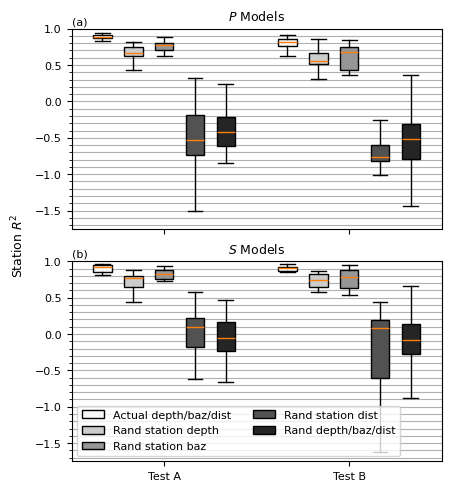

In [19]:

xtick_locs = [0, 1.25]
xlims=[-0.25, 2.25]
if replace_all:
    xtick_locs = [0, 1.5]
    xlims=[-0.25, 2.75]

if use_mean:
    plotting.r2_boxplots(boxplots_dict,
                        scatter_dict,
                        label_dict,
                        xtick_locs=xtick_locs,
                        xlims=xlims,
                        plot_train=False,
                        ylim=[-0.95, 1.],
                        legend_ax=1,
                        savefigname=figname,
                        figsize=(4.4, 4.8),
                        bp_colors=bp_colors,
                        yticks={'major':0.5, 'minor':0.1},
                        legend_ncols=2)
else:
    plotting.r2_boxplots(boxplots_dict,
                        scatter_dict,
                        label_dict,
                        xtick_locs=xtick_locs,
                        xlims=xlims,
                        plot_train=False,
                        ylim=[-1.75, 1.],
                        legend_ax=1,
                        savefigname=figname,
                        figsize=(4.4, 4.8),
                        bp_colors=bp_colors,
                        yticks={'major':0.5, 'minor':0.1},
                        legend_ncols=2)

In [20]:
p_results[['test_r2', 'holdout_r2']].median()

test_r2       0.887
holdout_r2    0.822
dtype: float64

In [21]:
p_depth_r2_df.median()

test_r2       0.662745
holdout_r2    0.553410
dtype: float64

In [22]:
p_baz_r2_df.median()

test_r2       0.769584
holdout_r2    0.674466
dtype: float64

In [23]:
p_dist_r2_df.median()

test_r2      -0.534161
holdout_r2   -0.763611
dtype: float64

In [24]:
print('depth:', p_results['test_r2'].median() - p_depth_r2_df['test_r2'].median())
print('baz:', p_results['test_r2'].median() - p_baz_r2_df['test_r2'].median())
print('dist:', p_results['test_r2'].median() - p_dist_r2_df['test_r2'].median())

depth: 0.2242551377328056
baz: 0.11741618937712583
dist: 1.4211607317869182


In [25]:
print('depth:', p_results['holdout_r2'].median() - p_depth_r2_df['holdout_r2'].median())
print('baz:', p_results['holdout_r2'].median() - p_baz_r2_df['holdout_r2'].median())
print('dist:', p_results['holdout_r2'].median() - p_dist_r2_df['holdout_r2'].median())

depth: 0.2685902922900768
baz: 0.14753412835971402
dist: 1.5856109499097242


S

In [26]:
s_results[['test_r2', 'holdout_r2']].median()

test_r2       0.9155
holdout_r2    0.9020
dtype: float64

In [27]:
s_depth_r2_df.median()

test_r2       0.764210
holdout_r2    0.740938
dtype: float64

In [28]:
p_baz_r2_df.median()

test_r2       0.769584
holdout_r2    0.674466
dtype: float64

In [29]:
p_dist_r2_df.median()

test_r2      -0.534161
holdout_r2   -0.763611
dtype: float64

In [30]:
print('depth:', s_results['test_r2'].median() - s_depth_r2_df['test_r2'].median())
print('baz:', s_results['test_r2'].median() - s_baz_r2_df['test_r2'].median())
print('dist:', s_results['test_r2'].median() - s_dist_r2_df['test_r2'].median())

depth: 0.15128983204139868
baz: 0.0892829158934133
dist: 0.813669916017538


In [31]:
print('depth:', s_results['holdout_r2'].median() - s_depth_r2_df['holdout_r2'].median())
print('baz:', s_results['holdout_r2'].median() - s_baz_r2_df['holdout_r2'].median())
print('dist:', s_results['holdout_r2'].median() - s_dist_r2_df['holdout_r2'].median())

depth: 0.16106219640525732
baz: 0.1231582246473909
dist: 0.8138603126068825
